In [2]:
from dataloader.dataloader_gliom import DataLoader_Gliom
import torchvision
import torchio as tio
get_foreground = tio.ZNormalization.mean

training_transform = tio.Compose([
          # to MNI space (which is RAS+)
    tio.RandomAnisotropy(p=0.25),              # make images look anisotropic 25% of times
                # tight crop around brain,        # standardize histogram of foreground
            # zero mean, unit variance of foreground
    tio.RandomBlur(p=0.25),                    # blur 25% of times
    tio.RandomNoise(p=0.25),                   # Gaussian noise 25% of times
    tio.OneOf({                                # either
                      # random affine
        tio.RandomElasticDeformation(): 0.12,   # or random elastic deformation
    }, p=0.1),                                 # applied to 80% of images
    tio.RandomBiasField(p=0.3),                # magnetic field inhomogeneity 30% of times
    tio.OneOf({                                # either
        tio.RandomMotion(): 1,                 # random motion artifact
        tio.RandomSpike(): 2,                  # or spikes
        tio.RandomGhosting(): 2,               # or ghosts
    }, p=0.1)                                # applied to 50% of images
])

In [3]:
import torch
datasets = DataLoader_Gliom(
    root_path='/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/*/*', save=False, png=False, 
    patch_size=256, slices=2, normalize='unit-variance',transform=training_transform)
data_loader = torch.utils.data.DataLoader(
    datasets, batch_size=1, num_workers=0)

In [15]:
images.shape

torch.Size([1, 697, 865, 10])

In [12]:
image,seg,images,segs,name=next(x)

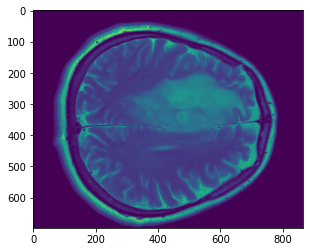

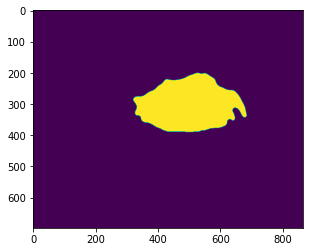

In [14]:
from matplotlib import pyplot as plt
plt.imshow(images[0,:,:,3])
plt.figure()
plt.imshow(segs[0,:,:,3])

In [150]:
import nibabel as nib

data=nib.load("/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0217/T0217/Anatomic/T2_TSE_TRA_448_5MM_YENI_0003/T2_TSE_TRA_448_5MM_YENI_0003.nii")

In [151]:
data=data.get_fdata()

In [152]:
seg=nib.load("/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0217/T0217/Segmentations/T0217_T2_HYP.nii").get_fdata()

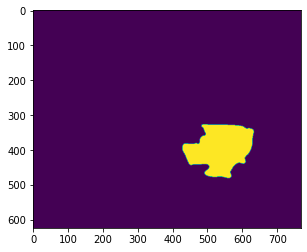

In [153]:
from matplotlib import pyplot as plt
plt.imshow(seg[:,:,14])


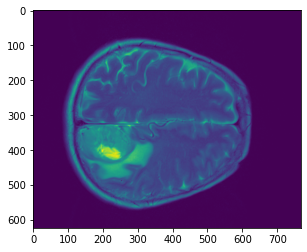

In [154]:
plt.imshow(data[:,:,14])


In [155]:
path='/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0204/T0204/Anatomic/T2_TSE_TRA_448_5MM_YENI_0003/T2_TSE_TRA_448_5MM_YENI_0003.nii'
data=nib.load(path).get_fdata()
seg='/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0204/T0204/Segmentations/T0204_T2_HYP.nii'
seg=nib.load(seg).get_fdata()

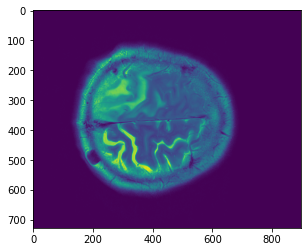

In [156]:
plt.imshow(data[:,:,18])

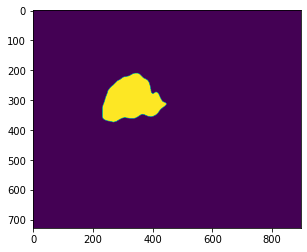

In [157]:
plt.imshow(seg[:,:,18])

In [158]:
x=next(it)



In [159]:
import glob 

glob.glob('/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/*/*/Segmentations/*T2*.nii*')

['/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0059/T0059/Segmentations/T0059_T2_HYP.nii',
 '/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0107/T0107/Segmentations/T0107_T2_HYP.nii',
 '/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0266/T0266/Segmentations/T0266_T2_HYP.nii',
 '/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/G0175/T0175/Segmentations/T0175_T2_HYP.nii',
 '/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_

In [160]:
import torch
import torch.nn as nn
import nibabel as nib
import glob
import cv2
from models.model import UNet, UNet3D
import src.preprocess as preprocess
import numpy as np
#import matplotlib.pyplot as plt
import time
from dataloader.dataloader_gliom import DataLoader_Gliom
from tqdm import tqdm
import src.losses.loss as loss
import wandb
from inference import load_model
from torchvision.utils import save_image
scaler = torch.cuda.amp.GradScaler()
device0= 'cuda:1' if torch.cuda.is_available() else 'cpu'
device1= 'cuda:0' if torch.cuda.is_available() else 'cpu'
config = dict(
    epochs=100,
    classes=2,
    kernels=[16, 32],
    batch_size=5,
    slices=10,
    device10=device0,
    device11=device1,
    patch_size=256,
    normalize='unit-variance',
    learning_rate=0.0001,
    weight_decay=0.0001,
    experiment='t2-hyp-segment',
    dataset="GLIOM-T2",
    architecture="UNET+Classifier")
wandb.login()

ls = []
prg = preprocess.preGlioma()
# nib.load('/cta/users/abas/Desktop/Meningiom/MeningiomData/gliom_data/Gliom/nii_gliom_boun/nii_gliom_directory/G0001/T0001/Segmentations/T0001_T2_HYP.nii')
"""
for t2_hyp in T2_HYP_segs:

    t2_root=('/').join(t2_hyp.split('/')[:-2])
    t2=glob.glob(t2_root+'/Anatomic/T2_TSE_TRA*/*.nii')[0]
    image=nib.load(t2).get_fdata().astype('float32').shape
    seg=nib.load(t2_hyp).get_fdata().astype('float32').shape
    if seg!=image:
        ls.append(t2_root)

"""


    

png = False
# datasets = DataLoader_Gliom(
#  '/cta/users/abas/Desktop/Meningiom/MeningiomData/gliom_data/Gliom/nii_gliom_boun/nii_gliom_directory/*/*/Segmentations/*T2_HYP*.nii',save=False,png=True)
datasets = DataLoader_Gliom(
    root_path='/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/*/*', save=False, png=False, 
    patch_size=256, slices=2, normalize='unit-variance')
data_loader = torch.utils.data.DataLoader(
    datasets, batch_size=1, num_workers=0)

datasets_validation = DataLoader_Gliom(
    root_path='/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/valid/*/*', save=False, png=False, 
    patch_size=256, slices=2, normalize='unit-variance')

data_loader_validation = torch.utils.data.DataLoader(
    datasets_validation, batch_size=1, num_workers=0)

bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
last = 0
first=False
test=True
if first:
    model = UNet(in_channels=3)

    checkpoint = "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt"
    state_dict = torch.hub.load_state_dict_from_url(
        checkpoint, progress=False, map_location='cpu')
    model.load_state_dict(state_dict)
    model.encoder1.enc1conv1.in_channels = 1
    model.encoder1.enc1conv1.weight = torch.nn.Parameter(
        torch.mean(model.encoder1.enc1conv1.weight, dim=1).unsqueeze(1))
    

    model.convClassifier = nn.Conv2d(
        in_channels=256, out_channels=128, kernel_size=3, stride=1)
    model.convClassifier2 = nn.Conv2d(
        in_channels=128, out_channels=64, kernel_size=5, stride=1)
    model.convClassifier3 = nn.Conv2d(
        in_channels=64, out_channels=32, kernel_size=3, stride=1)    
    model.classifier = nn.Linear(in_features=2048, out_features=1024)
    model.classifier2 = nn.Linear(in_features=1024, out_features=256)
    model.classifier3 = nn.Linear(in_features=256, out_features=1)

    

elif test:
    model=UNet()
    model.convClassifier = nn.Conv2d(
        in_channels=256, out_channels=128, kernel_size=3, stride=1)
    model.convClassifier2 = nn.Conv2d(
        in_channels=128, out_channels=64, kernel_size=5, stride=1)
    model.convClassifier3 = nn.Conv2d(
        in_channels=64, out_channels=32, kernel_size=3, stride=1)    
    model.classifier = nn.Linear(in_features=2048, out_features=1024)
    model.classifier2 = nn.Linear(in_features=1024, out_features=256)
    model.classifier3 = nn.Linear(in_features=256, out_features=1)
    model=load_model('/cta/users/abas/Desktop/segmentation/t2_hyp_segment/checkpoints/model_256_0.896_best.pt',model)

else:
    model = UNet(phase='test')
    #model = load_model('/cta/users/abas/Desktop/Meningiom/MeningiomData/model_0.654_best.pt',model)

model = model.to(device1)
model = model.train()
epochs = config['epochs']

optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])

pbar = tqdm(range(0, epochs))
ls_epoch = 0
loss_hs = []
best_val_loss=99
bce_epoch = 0

In [161]:

with wandb.init(project=config['experiment'], config=config):
    for idx, epoch in enumerate(pbar):
        ls_datas = 0
        pbar2 = tqdm(data_loader)
        nk=0
        for dt_idx, data in enumerate(pbar2):
                images, segs, img, seg_o, name = data
                pbar2.set_description('Epoch: %d' % epoch)
                ls_data = 0
                nk+=1
                n=1e-6
                
                for idc, (image, seg) in enumerate(zip(images, segs)):
                    

                    n += 1
                

                    image=image.permute(3,0,1,2).to(device1)
                    output= model(image)
                    optimizer.zero_grad()

                    loss_value = loss.dice_loss(output, seg.permute(
                        3, 0, 1, 2).to(device1).to(torch.long))

                    if loss_value.item() > 1.5:
                        save_image(torch.stack(((image[0, :, :, 0].squeeze().to(device1) > 0).float(), (output[0, 0].squeeze() > 0.95).float(), (seg[0, :, :, 0].squeeze().to(
                            device1) > 0).float()), dim=0), f'/cta/users/abas/Desktop/Meningiom/MeningiomData/model_images/{name}_{idx}_{dt_idx}_{idc}.png')

                    # scaler.scale(loss_value).backward()
                    # scaler.step(optimizer)
                    # scaler.update()
                    loss_value.backward()
                    optimizer.step()
                    ls = loss_value.item()
                    ls_data += ls

                    pbar.set_description(
                        f'dt_idx:{dt_idx},data: {name} ,lossval: {ls:.3f}, Per Data Loss:{(ls_data/(n)):.3f}')
                    wandb.log({"Dice loss Patch": ls,
                           "Subject":name,"id":idc})
                ls_datas += (ls_data/n)
                wandb.log({"Dice loss Data": ls_data/n
                           ,"Subject":name})

            # loss_hs.append(ls_datas/(dt_idx+1))
        ls_epoch = (ls_datas/nk)
        
    
        #wandb.watch(model, bce_loss, log="all", log_freq=15)
        #wandb.watch(model, loss.dice_loss, log="all", log_freq=15)

        wandb.log({"epoch": idx, "Dice loss Epoch": ls_epoch,
                   })
        

       

        with torch.no_grad():
            pbar2 = tqdm(data_loader_validation)
            ls_datas_val=0
            for dt_idx, data in enumerate(pbar2):
                    images, segs, img, seg_o, name = data
                    if images == 1:
                        continue
                    pbar2.set_description('Epoch: %d' % epoch)
                    ls_data_val = 0
                    nk = 0
                    n=1e-6
                    for idc, (image, seg) in enumerate(zip(images, segs)):
                       
                        # print(lbl,'*'*100)
                        n += 1
                        # seg[:,:,:,0]=seg[:,:,:,0]*1
                        # seg[:,:,:,1]=seg[:,:,:,1]*2
                        # seg[:,:,:,2]=seg[:,:,:,2]*3
                        # seg=torch.sum(seg,dim=3)

                        #cls_out = efficient_model_pretrained(
                        #    image.permute(3, 0, 1, 2).to(device0))
                        #cls_out = classifier_model(cls_out)
                        #bce_loss_value_eff = bce_loss(
                        #    cls_out, lbl.to(device0).unsqueeze(1))
                        #bce_loss_value_eff_data_val += bce_loss_value_eff.item()

                        #output = model(image.permute(3, 0, 1, 2).to(device1))
                        output = model(image.permute(3, 0, 1, 2).to(device1))
                       
                        loss_value = loss.dice_loss(output, seg.permute(
                            3, 0, 1, 2).to(device1).to(torch.long))

                        ls = loss_value.item()
                        ls_data_val += ls

                        pbar.set_description(
                            f'Val dt_idx:{dt_idx},data: {name} ,lossval: {ls:.3f}, Per Data Loss:{(ls_data/(n)):.3f}')
                    ls_datas_val += ls_data_val/n
                    
                    wandb.log({"Dice Val loss Per Data": ls_data_val/n
                            ,"Subject":name})
            # loss_hs.append(ls_datas/(dt_idx+1))
        ls_epoch_val = (ls_datas_val/len(data_loader_validation))
       
        
        print(
            f'Epoch: {idx}, Val Dice Loss:{ls_epoch_val:.3f} ')
        #wandb.watch(model, bce_loss, log="all", log_freq=15)
        #wandb.watch(model, loss.dice_loss, log="all", log_freq=15)

        wandb.log({ "Val Dice loss Epoch": ls_epoch_val,
                   })
        if ls_epoch_val<best_val_loss:
            best_val_loss=ls_epoch_val
            torch.save(model.state_dict(), f"/cta/users/abas/Desktop/segmentation/t2_hyp_segment/checkpoints/model_{config['patch_size']}_{ls_epoch_val:.3f}_best.pt")
        
    """
    ls=[]
    unique_dims=[]
    for t2_hyp in T2_HYP_segs:

        t2_root=('/').join(t2_hyp.split('/')[:-2])
        t2=glob.glob(t2_root+'/Anatomic/T2_TSE_TRA*/*.nii')[0]
        image=nib.load(t2).get_fdata().astype('float32')
        seg=nib.load(t2_hyp).get_fdata().astype('float32')
        inplane,inplane2,slices=seg.shape

        if seg.shape not in unique_dims:
            unique_dims.append(seg.shape)
        if seg.shape!=image.shape:
            ls.append(t2_root.split('/')[-1])
        else:    
            for idx,slice in enumerate(range(0,slices)):
                # time.sleep(0.5)
                dst = cv2.addWeighted(prg.normalize(image[:,:,slice]),
                0.8,prg.normalize(seg[:,:,slice]),0.4,0)
                cv2.imshow('Normal Image',dst)
            
                if cv2.waitKey(50) & 0xFF == ord('q'):
                    break

    cv2.destroyAllWindows()
    """


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade




InvalidVersionSpec: Invalid version '4.1torch>=1.4': invalid character(s)




















Epoch: 0:   3%|▎         | 9/291 [00:27<14:35,  3.10s/it]
dt_idx:9,data: ('G0166',) ,lossval: 0.194, Per Data Loss:0.256:   0%|          | 0/100 [00:35<?, ?it/s]


Dice loss Data,▇▆▆▆▁▇▇█▆
Dice loss Patch,███▃▂██████▂██▆▂██▃▁▁██████████████████▂
id,▁▂▃▃▄▅▅▆▇▂▁▂▂▃▁▂▂▃▁▂▂▁▃▃▁▂▃▁▂▁▂▃▄▄▅▆▇▇█▂
Dice loss Data,0.86134
Dice loss Patch,0.19395
id,22


KeyboardInterrupt: 

In [17]:
import nibabel as nib

with open('/cta/users/abas/Desktop/segmentation/suspected.txt', 'r') as f:
    string = f.read()



In [ ]:
arr=np.unique(string.split('\n'))[1::]
adana=[]

In [ ]:
adana[15::]

['G0198',
 'G0207',
 'G0209',
 'G0210',
 'G0211',
 'G0212',
 'G0214',
 'G0216',
 'G0217',
 'G0219',
 'G0220',
 'G0221',
 'G0223',
 'G0224',
 'G0225',
 'G0226',
 'G0263',
 'G0329',
 'G0334',
 'G0336',
 'G0340']

In [ ]:
arr

array(['G0040', 'G0041', 'G0043', 'G0046', 'G0047', 'G0048', 'G0051',
       'G0052', 'G0053', 'G0054', 'G0055', 'G0056', 'G0058', 'G0059',
       'G0060', 'G0061', 'G0063', 'G0064', 'G0065', 'G0066', 'G0067',
       'G0068', 'G0070', 'G0071', 'G0072', 'G0073', 'G0074', 'G0075',
       'G0080', 'G0081', 'G0082', 'G0083', 'G0084', 'G0086', 'G0087',
       'G0088', 'G0090', 'G0092', 'G0097', 'G0098', 'G0100', 'G0102',
       'G0103', 'G0105', 'G0107', 'G0108', 'G0109', 'G0110', 'G0112',
       'G0114', 'G0115', 'G0118', 'G0119', 'G0121', 'G0122', 'G0123',
       'G0125', 'G0127', 'G0128', 'G0130', 'G0135', 'G0136', 'G0137',
       'G0138', 'G0139', 'G0140', 'G0141', 'G0143', 'G0145', 'G0147',
       'G0148', 'G0150', 'G0151', 'G0152', 'G0153', 'G0154', 'G0155',
       'G0161', 'G0162', 'G0163', 'G0165', 'G0166', 'G0167', 'G0168',
       'G0170', 'G0171', 'G0172', 'G0174', 'G0175', 'G0177', 'G0178',
       'G0179', 'G0180', 'G0181', 'G0182', 'G0183', 'G0184', 'G0186',
       'G0187', 'G01

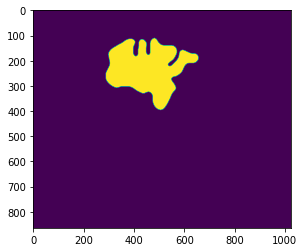

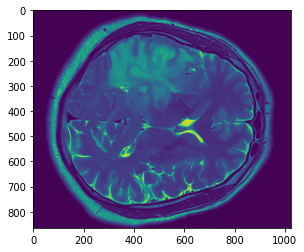

In [22]:
from IPython.display import clear_output
import numpy as np
arx=['G0222','G0176','G0062','G0054','G0168','G0232','G0138']
for dx in arx:
    path=f'/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/{dx}/*/Anatomic/*T2_TSE_TRA*/*T2_TSE_TRA*.nii'
    seg=f'/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/train/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/raw/Gliom/nii_gliom_boun/nii_gliom_directory/{dx}/*/Segmentations/*T2_HYP*.nii'
    import glob 

    data=glob.glob(path)[0]
    seg=glob.glob(seg)[0]

    data=nib.load(data).get_fdata().astype('float32')
    seg=nib.load(seg).get_fdata().astype('float32')

    nonzers=np.where(seg==1)[2]
    slicex=int(np.median(nonzers))+2
    plt.imshow(seg[:,:,slicex])
    plt.show()
    plt.figure()
    plt.imshow(data[:,:,slicex])
    plt.show()
    ad=input('Ok?')
    if ad=='n':
        adana.append(dx)
    clear_output(wait=True)

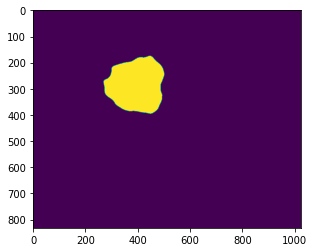

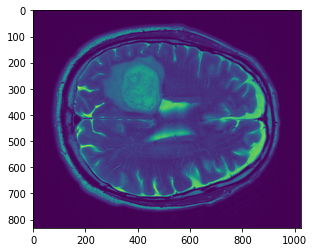

In [ ]:



arr2=['G0001','G0002','G0003','G0004','G0005','G0006','G0008','G0009','G0030','G0031','G0032','G0033','G0034','G0035','G0036','G0037','G0038']


from IPython.display import clear_output

adana2=[]
for dx in arr2:

    path=f'/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/valid/{dx}/*/Anatomic/*T2_TSE_TRA*/*T2_TSE_TRA*.nii'

    seg=f'/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/valid/{dx}/*/Segmentations/*T2_HYP*.nii'
    import glob 

    data=glob.glob(path)[0]
    seg=glob.glob(seg)[0]

    data=nib.load(data).get_fdata().astype('float32')
    seg=nib.load(seg).get_fdata().astype('float32')

    nonzers=np.where(seg==1)[2]
    slicex=int(np.median(nonzers))
    plt.imshow(seg[:,:,slicex])
    plt.show()
    plt.figure()
    plt.imshow(data[:,:,slicex])
    plt.show()
    ad=input('Ok?')
    if ad=='n':
        adana2.append(dx)
    clear_output(wait=True)



In [ ]:
dx

'G0038'

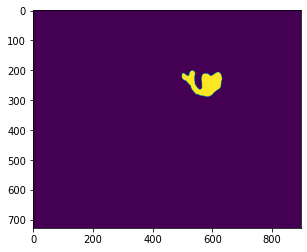

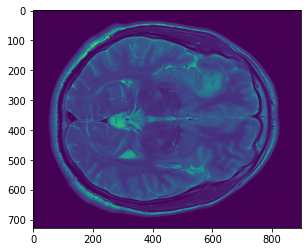

In [ ]:



arr2=['G0010','G0011','G0012','G0013','G0014','G0015','G0016','G0017','G0018','G0019','G0020','G0021','G0022','G0023','G0024','G0025','G0026','G0027','G0028','G0029']


from IPython.display import clear_output

adana2=[]
for dx in arr2:

    path=f'/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/test/{dx}/*/Anatomic/*T2_TSE_TRA*/*T2_TSE_TRA*.nii'

    seg=f'/cta/users/abas/Desktop/segmentation/t2_hyp_segment/data/test/{dx}/*/Segmentations/*T2_HYP*.nii'
    import glob 

    data=glob.glob(path)[0]
    seg=glob.glob(seg)[0]

    data=nib.load(data).get_fdata().astype('float32')
    seg=nib.load(seg).get_fdata().astype('float32')

    nonzers=np.where(seg==1)[2]
    slicex=int(np.median(nonzers))
    plt.imshow(seg[:,:,slicex])
    plt.show()
    plt.figure()
    plt.imshow(data[:,:,slicex])
    plt.show()
    ad=input('Ok?')
    if ad=='n':
        adana2.append(dx)
    clear_output(wait=True)



In [ ]:
adana2

['G0011', 'G0013', 'G0014', 'G0015', 'G0016', 'G0017', 'G0020']

In [ ]:
sudo mount -t cifs -o username=admin,password=compimglab12345,uid=$(id -u),gid=$(id -g),file_mode=0664,dir_mode=0777,forceuid,forcegid //79.123.179.29/Ambar raw/


In [5]:
import torchio as tio

In [133]:
get_foreground = tio.ZNormalization.mean

training_transform = tio.Compose([
          # to MNI space (which is RAS+)
    tio.RandomAnisotropy(p=0.25),              # make images look anisotropic 25% of times
                # tight crop around brain,        # standardize histogram of foreground
            # zero mean, unit variance of foreground
    tio.RandomBlur(p=0.25),                    # blur 25% of times
    tio.RandomNoise(p=0.25),                   # Gaussian noise 25% of times
    tio.OneOf({                                # either
                      # random affine
        tio.RandomElasticDeformation(): 0.12,   # or random elastic deformation
    }, p=0.1),                                 # applied to 80% of images
    tio.RandomBiasField(p=0.3),                # magnetic field inhomogeneity 30% of times
    tio.OneOf({                                # either
        tio.RandomMotion(): 1,                 # random motion artifact
        tio.RandomSpike(): 2,                  # or spikes
        tio.RandomGhosting(): 2,               # or ghosts
    }, p=0.1)                                # applied to 50% of images
])

training_transform_spatial=tio.Compose([

    
    tio.RandomFlip(p=0.5),
    
    
                                 # applied to 50% of images
])



In [87]:
out=training_transform(images.numpy())

In [88]:
images.shape

torch.Size([1, 687, 873, 5])

In [98]:
import random
import numpy as np
seed = np.random.randint(2147483647) # make a seed with numpy generator 
random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7

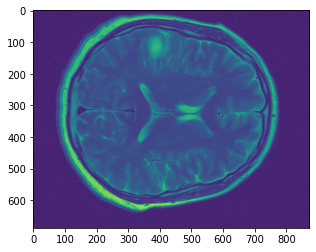

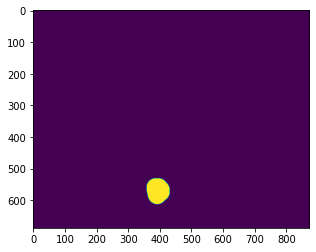

In [150]:
seed = np.random.randint(2147483647) # make a seed with numpy generator 

np.random.seed(seed=seed)
random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7
out=training_transform(images.numpy(),)
np.random.seed(seed=seed)
random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7
out=training_transform_spatial(out,)


from matplotlib import pyplot as plt
plt.imshow(out[0,:,:,0])
plt.figure()
np.random.seed(seed=seed)

random.seed(seed) # apply this seed to img tranfsorms
torch.manual_seed(seed) # needed for torchvision 0.7
out_seg=training_transform_spatial(segs.numpy(),)

plt.imshow(out_seg[0,:,:,0])


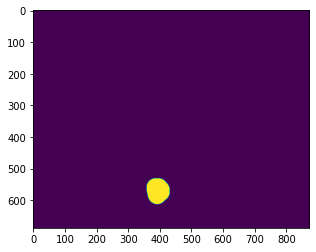

In [67]:
plt.imshow(segs[0,:,:,0])
